***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">MHM Pre</span> 

# Helmholtz Machine MNIST MIM


*Created:* April 13, 2025


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.cuda.is_available()

True

In [2]:
def para_init(n_dz,dev):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,0,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    return Phi,Theta

In [3]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [4]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    x = x.type(torch.float)
    q = sigmoid(torch.matmul(param,x))
    return q

In [5]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [6]:
def log(p):
    q = torch.where(p != 0, torch.log(p), -20) # replace log(0) with -100
    return q

In [7]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * log(q) + (1-y) * log(1-q)).mean()
    return loss

In [8]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [9]:
def layer_wise_train(input_x,param_xy,param_yx,lr):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [10]:
def wake_phase(Phi,Theta,data,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [11]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
    return Phi, Loss

In [12]:
def wake_phase_ws_fixed(Phi,Theta,fixed_sample,fixed_layer,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    fixed_sample -- scheduled sampling at each hierchical layer. Python dictionary of length fixed_layer.
                    Each element is a torch tensor of shape (n_dz[i],batch_size)
    fixed_layer -- Torch tensor of values 0 and 1 of length n_layer. 1 indicates the layers with fixed samples.
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Loss -- layer-wise loss top-down. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = fixed_sample['Layer_0'].shape[1]
    input_x = fixed_sample['Layer_0']
    for i in range(n_layer-2):
        if fixed_layer[i+1] == 0:
            output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
            layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
            input_x = output_y
        else:
            Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
            one_step_update(fixed_sample['Layer_'+str(i+1)],input_x,Theta["Theta_" + str(i+1) + str(i)],lr)
            input_x = fixed_sample['Layer_'+str(i+1)]
        
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [13]:
def sleep_phase_ws_fixed(Phi,Theta,fixed_sample,fixed_layer,lr,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    fixed_sample -- scheduled sampling at each hierchical layer. Python dictionary of length fixed_layer.
                    Each element is a torch tensor of shape (n_dz[i],batch_size)
    fixed_layer -- Torch tensor of values 0 and 1 of length n_layer. 1 indicates the layers with fixed samples.
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = fixed_sample['Layer_0'].shape[1]
    unit = torch.ones(1,batch_size,dtype=int,device=dev)
    if fixed_layer[n_layer-2] == 0:
        input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    else:
        input_x = fixed_sample['Layer_'+str(n_layer-2)]
    
    for i in range(n_layer-2,0,-1):
        if fixed_layer[i-1] == 0:
            output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
            layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
            input_x = output_y
        else:
            Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
            one_step_update(fixed_sample['Layer_'+str(i-1)],input_x,Phi["Phi_" + str(i-1) + str(i)],lr)
            input_x = fixed_sample['Layer_'+str(i-1)]
    return Phi, Loss

In [14]:
def wake_sample_org(Phi,data,fixed_layer,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    fixed_layer -- Torch tensor of values 0 and 1 of length n_layer. 1 indicates the layers with fixed samples.
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    index = torch.where(fixed_layer==1)[0]
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    for i in range(n_layer-2):
        q = one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)])
        input_x = sample(q,dev)
        Recog_sample["Layer_" + str(index[i+1].item())] = input_x
    return Recog_sample

In [15]:
def sleep_sample_org(Theta,gen_batch_size,fixed_layer,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    fixed_layer -- Torch tensor of values 0 and 1 of length n_layer. 1 indicates the layers with fixed samples.
    dev -- torch device
    
    Returns:
    Gen_sample -- set of top-down generations for hierarchical layers. len(Gen_sample) = n_layer-1. For every layer, 
                    gen_sample is of shape (n_y, gen_batch_size)
    """
    n_layer = len(Theta) + 1
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    index = torch.where(fixed_layer==1)[0]
    Gen_sample = {}
    for i in range(n_layer-1,0,-1):
        q = one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)])
        input_x = sample(q,dev)
        Gen_sample["Layer_" + str(index[i-1].item())] = input_x
    return Gen_sample

In [16]:
def one_step_prob_entropy(q):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    p_y -- Bernoulli probability of each neuron at layer Y. Torch tensor of shape (n_y,)
    H_Y -- factorial entropy at output layer Y, a tensor number
    H_YX -- conditional entropy from layer X to Y, a tensor number
    """
    p_yx = q.t()   # (batch_size,n_y)
    H_YX = entropy_bernoulli(p_yx).mean() # tensor number
    p_y = p_yx.mean(axis=0) # (n_y,)
    H_Y = entropy_bernoulli(p_y) # tensor number
    return H_Y, H_YX

In [17]:
def wake_sample(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    H_Y_wake = torch.zeros(n_layer-2)
    H_YX_wake = torch.zeros(n_layer-2)
    for i in range(n_layer-2):
        q = one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)])
        H_Y_wake[i], H_YX_wake[i] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample, H_Y_wake, H_YX_wake

In [18]:
def sleep_sample(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    Gen_sample -- set of top-down generations for hierarchical layers. len(Gen_sample) = n_layer-1. For every layer, 
                    gen_sample is of shape (n_y, gen_batch_size)
    """
    n_layer = len(Theta) + 1
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    Gen_sample = {}
    H_Y_sleep = torch.zeros(n_layer-1)
    H_YX_sleep = torch.zeros(n_layer-1)
    for i in range(n_layer-1,0,-1):
        q = one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)])
        H_Y_sleep[i-1], H_YX_sleep[i-1] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
        Gen_sample["Layer_" + str(i-1)] = input_x
    return Gen_sample, H_Y_sleep, H_YX_sleep

In [19]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    dcm = (2**torch.arange(width).flip(0).to(dev).reshape(-1,1) * bnr).sum(axis=0)
    return dcm

In [20]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [21]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * log(p)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * log(P)).sum(axis=1,keepdims=True)
    return H

In [22]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber * log(P_ber) + (1-P_ber) * log(1-P_ber))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [23]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*log(q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [24]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*log(p) - p*log(q) + (1-p)*log(1-p) - (1-p)*log(1-q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [25]:
def MI_sample_batch(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    
    # minimum H(Y)
    p_y = q.mean(axis=1,keepdim=True) # (n_y,1)
    p_sample = (p_y < 0.5).long()
    output_y = sample(q,dev) # (n_y,batch_size)
    
    mask = ((q - 0.5).abs() - (p_y - 0.5).abs() > 0).long()
    y_sample = mask * q_sample + (1-mask) * p_sample
    
    output_y = y_sample
#     output_y[:,int(batch_size/2)] = y_sample[:,int(batch_size/2)]
    
    return output_y

In [26]:
def MI_sample_batch_acc(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    
    # minimum H(Y)
    p_y = q.mean(axis=1) # (n_y,)
    output_y = sample(q,dev) # (n_y,batch_size)
    
    for i in range(batch_size):
        p_sample = (p_y < 0.5).long()
        mask = ((q[:,i] - 0.5).abs() - (p_y - 0.5).abs() > 0).long()
        y_sample = mask * q_sample[:,i] + (1-mask) * p_sample
        output_y[:,i] = y_sample
        p_y = (1-eps)*p_y + eps*y_sample
    
    return output_y

In [27]:
def MI_sample_batch_acc_sample(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    
    # minimum H(Y)
    output_y = sample(q,dev) # (n_y,batch_size)
#     output_y = q_sample
    col_ind = np.arange(batch_size)
    
    for i in range(int(batch_size/3)):
        p_y = output_y[:,col_ind != i].float().mean(axis=1)
        p_sample = (p_y < 0.5).long()
        mask = ((q[:,i] - 0.5).abs() - (p_y - 0.5).abs() > 0).long()
        y_sample = mask * q_sample[:,i] + (1-mask) * p_sample
        output_y[:,i] = y_sample
    
    return output_y

In [28]:
def MI_sample_batch_comp(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    n_y = q.shape[0]
    output_y = sample(q,dev) # (n_y,batch_size)
    col_ind = np.arange(batch_size)
    
    for j in range(batch_size):
        q_yx_0 = q[0,j]  # p(y|x)
        p_y_0 = output_y[0,col_ind!=j].float().mean() #p(y)
        if (q_yx_0 - 0.5).abs() > (p_y_0 - 0.5).abs():
            output_y[0,j] = (q_yx_0 > 0.5).long()
        else:
            output_y[0,j] = (p_y_0 < 0.5).long()
        
        for i in range(1,n_y):
            q_yx_i = q[i,j]
            p_y_i = output_y[i,col_ind!=j].float().mean()
            k = 1
            ind0 = torch.where(output_y[:i,j] == 0)[0]
            ind1 = torch.where(output_y[:i,j] == 1)[0]
            if len(ind0) != 0:
                ind_choice = torch.where((output_y[ind0,:]).sum(axis=0) == 0)[0]
                if len(ind_choice) > 1:
                    p_y_0 = output_y[i,ind_choice[ind_choice != j]].float().mean()
                    p_y_i = p_y_i + p_y_0
                    k += 1
            if len(ind1) != 0:
                ind_choice = torch.where((output_y[ind1,:]).sum(axis=0) == len(ind1))[0]
                if len(ind_choice) > 1:
                    p_y_1 = output_y[i,ind_choice[ind_choice != j]].float().mean()
                    p_y_i = p_y_i + p_y_1
                    k += 1
            p_y_i = p_y_i/k

            if (q_yx_i - 0.5).abs() > (p_y_i - 0.5).abs():
                output_y[i,j] = (q_yx_i > 0.5).long()
            else:
                output_y[i,j] = (p_y_i < 0.5).long()
    return output_y

In [29]:
def MI_train_batch(input_x,param_xy,param_yx,lr,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    param_yx -- parameters from y to x. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    param_yx -- updated parameters from y to x
    loss -- cross entropy loss at layer x
    """
    output_y = MI_sample_batch_acc(input_x,param_xy,eps,dev)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)

    return output_y, param_yx, loss

In [30]:
def wake_phase_MI_batch(Phi,Theta,data,lr,Epsilon,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Loss[i] = \
        MI_train_batch(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,Epsilon[i],dev)
        input_x = output_y
        
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [31]:
def sleep_phase_MI_batch(Phi,Theta,gen_batch_size,lr,Epsilon_s,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    num -- number of random samples selected for training
    lr -- learning rate
    Epsilon_s -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Loss[i] = \
        MI_train_batch(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr,Epsilon_s[i-1],dev)
        input_x = output_y
    return Phi, Loss

## Model

In [32]:
dev = torch.device('cuda')

In [33]:
structure_org = [784,686,588,490,392,294,196,98,49,25,1] #11
structure = [784,735,686,637,588,539,490,441,392,343,294,245,196,147,98,49,25,10,1] #19
n_dz = torch.tensor(structure)
n_layer = len(n_dz)
n_d = n_dz[0]

In [34]:
fixed_layer = torch.zeros(n_layer,dtype=int)
k = 0
for i in range(n_layer):
    if structure[i] == structure_org[k]:
        fixed_layer[i] = 1
        k = k+1

In [35]:
fixed_layer

tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1])

In [36]:
torch.where(fixed_layer==1)[0]

tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 15, 16, 18])

In [37]:
image_binary = torch.load('D:\deep music\MNIST\MNIST\MNIST_binary.pt',dev,weights_only=True)
image_binary.shape

torch.Size([60000, 28, 28])

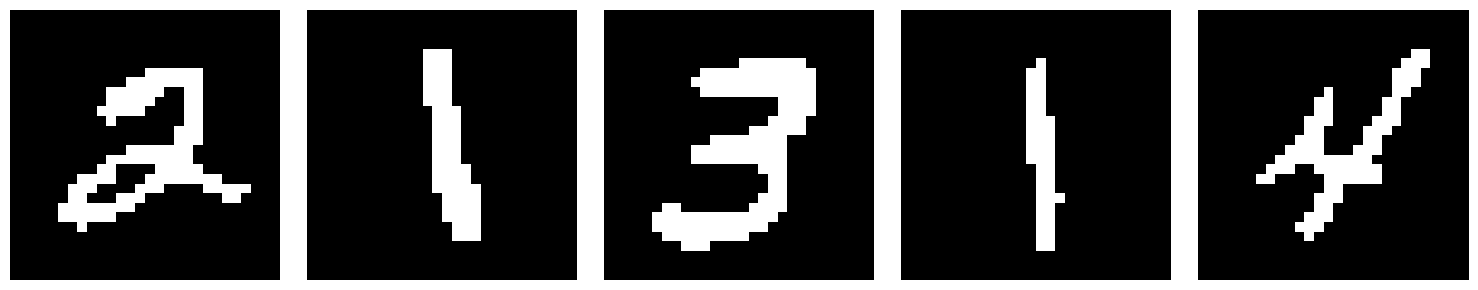

In [38]:
# Create a figure to display the images
plt.figure(figsize=(15, 3))

# Print the first few images in a row
for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(image_binary[i+5,:,:].to('cpu').numpy(), cmap='gray')
#         plt.imshow(image.squeeze()[i+300,:,:].to('cpu').numpy(), cmap='gray')
#         plt.title(f"Label: {label[i+5].item()}")
        plt.axis('off')
plt.tight_layout()
plt.show()

In [39]:
data = image_binary.reshape(-1,784).t()
data.shape

torch.Size([784, 60000])

In [40]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_I_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Gen_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Gen_I_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Phi_Loss_Layer_4',
 'Phi_Loss_Layer_5',
 'Phi_Loss_Layer_6',
 'Phi_Loss_Layer_7',
 'Phi_Loss_Layer_8',
 'Phi_Loss_Layer_9',
 'Phi_Loss_Layer_10',
 'Phi_Loss_Layer_11',
 'Phi_Loss_Layer_12',
 'Phi_Loss_Layer_13',
 'Phi_Loss_Layer_14',
 'Phi_Loss_Layer_15',
 'Phi_Loss_Layer_16',
 'Phi_Loss_Layer_17',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Theta_Loss_Layer_4',
 'Theta_Loss_Layer_5',
 'Theta_Loss_Layer_6',
 'Theta_Loss_Layer_7',
 'Theta_Loss_Layer_8',
 'Theta_Loss_Layer_9',
 'Theta_Loss_Layer_10',
 'Theta_Loss_Layer_11',
 'Theta_Loss_Layer_12',
 'Theta_Loss_Layer_13',
 'Theta_Loss_Layer_14',
 'Theta_Loss_Layer_15',
 'Theta_Loss_Layer_16',
 'Theta_Loss_Layer_17',
 'Recog_H_Layer_1',
 'Recog_H_Layer_2',
 'Recog_H_Layer_3',
 'Recog_H_Layer_4',
 'Recog_H_Layer_5',
 'Recog_H_Layer_6',
 'Recog_H_Layer_7',
 'Recog_H_Layer_8',
 'Recog_H_Layer_9',
 'Recog_H_Layer_10',
 'Recog_H_La

In [41]:
len(col_list)

104

## Training

In [73]:
Analytic_MNIST_11_19 = pd.DataFrame(columns=col_list)
Analytic_MNIST_11_19

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Phi_Loss_Layer_8,Phi_Loss_Layer_9,Phi_Loss_Layer_10,...,Gen_I_Layer_8,Gen_I_Layer_9,Gen_I_Layer_10,Gen_I_Layer_11,Gen_I_Layer_12,Gen_I_Layer_13,Gen_I_Layer_14,Gen_I_Layer_15,Gen_I_Layer_16,Gen_I_Layer_17


In [74]:
Phi,Theta = para_init(n_dz,dev)

In [75]:
para = torch.load('D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Parameters_MNIST_new_batch5000', dev,weights_only=True)
Phi_org = para['Phi']
Theta_org = para['Theta']

In [57]:
Analytic_MNIST_11_19 = pd.read_csv('D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Analytic_MNIST_11_19_MI.csv', sep=",")
Analytic_MNIST_11_19

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Phi_Loss_Layer_8,Phi_Loss_Layer_9,Phi_Loss_Layer_10,...,Gen_I_Layer_8,Gen_I_Layer_9,Gen_I_Layer_10,Gen_I_Layer_11,Gen_I_Layer_12,Gen_I_Layer_13,Gen_I_Layer_14,Gen_I_Layer_15,Gen_I_Layer_16,Gen_I_Layer_17
0,0.692537,0.724160,0.690162,0.783817,0.693006,0.316530,0.693127,0.249002,0.693141,0.258326,...,0.001953,0.111725,0.001205,0.145355,0.000656,0.196640,0.000435,0.503342,0.223152,0.038549
1,0.689093,0.715185,0.678738,0.786605,0.691499,0.286942,0.692540,0.206876,0.692852,0.212565,...,0.028717,0.171379,0.018524,0.128376,0.011871,0.129486,0.007881,12.627689,7.786806,0.119610
2,0.685041,0.701876,0.677975,0.776703,0.691361,0.284174,0.692516,0.206705,0.692900,0.212578,...,0.029846,0.183670,0.019135,0.136009,0.012558,0.134941,0.009583,14.931963,9.135971,0.118531
3,0.678136,0.722380,0.677750,0.792361,0.691414,0.285519,0.692594,0.206366,0.692861,0.212303,...,0.029358,0.177177,0.019058,0.140381,0.013229,0.130051,0.008980,15.791649,9.641088,0.119312
4,0.668428,0.737649,0.677669,0.793454,0.691318,0.285923,0.692584,0.205637,0.692859,0.211704,...,0.029175,0.186867,0.019394,0.139744,0.013290,0.134178,0.010078,16.264225,9.892921,0.119182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9945,0.240435,0.106880,0.237248,0.199433,0.219223,0.215802,0.198978,0.240739,0.164593,0.241484,...,93.346657,91.298378,70.186890,78.112732,63.419071,63.088802,53.789604,26.106499,16.570967,5.228916
9946,0.240879,0.106902,0.237470,0.198945,0.219652,0.215574,0.199371,0.240532,0.164775,0.241443,...,93.118706,91.320435,69.866241,78.108070,63.194138,63.005978,53.765923,26.128429,16.570457,5.232137
9947,0.240486,0.106823,0.237411,0.198879,0.219615,0.215568,0.199289,0.240164,0.164835,0.241159,...,93.061790,91.276443,69.965454,78.091309,63.301006,63.150925,53.868362,26.182800,16.577406,5.236228
9948,0.239858,0.106966,0.236890,0.199221,0.218798,0.216181,0.198384,0.241080,0.164015,0.241496,...,93.232185,91.658310,70.017517,78.329285,63.330196,63.156281,53.842602,26.157307,16.580921,5.228728


In [55]:
para = torch.load('D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Parameters_MNIST_11_19_MI', dev,weights_only=True)
Phi = para['Phi']
Theta = para['Theta']

In [86]:
lr = 0.1
epoch = 10
batch_size = 5000
gen_batch_size = 10000
n_data = data.shape[1]
batch_num = int(n_data/batch_size)
batch_num

12

In [87]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    for i in range(batch_num):
        Recog_sample_org = wake_sample_org(Phi_org,data[:,index[i*batch_size:(i+1)*batch_size]],fixed_layer,dev)
        Gen_sample_org = sleep_sample_org(Theta_org,batch_size,fixed_layer,dev)

        Theta, Loss_sleep = wake_phase_ws_fixed(Phi,Theta,Recog_sample_org,fixed_layer,lr,dev)
        Phi, Loss_wake = sleep_phase_ws_fixed(Phi,Theta,Gen_sample_org,fixed_layer,lr,dev)
        
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    if e%100 == 0:
        print('Loss_wake:',Loss_W/batch_num,'    Loss_sleep:',Loss_S/batch_num)
        stat = []
        stat = stat + list((Loss_W[1:]/batch_num).to('cpu').numpy())
        stat = stat + list((Loss_S/batch_num).to('cpu').numpy())

        Recog_sample, H_Y_wake, H_YX_wake = wake_sample(Phi,data[:,index[:10000]],dev)
        Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)

        stat = stat + list(H_Y_wake.to('cpu').numpy()) + list((H_Y_wake - H_YX_wake).to('cpu').numpy()) \
                + list(H_Y_sleep.to('cpu').numpy()) + list((H_Y_sleep - H_YX_sleep)[:-1].to('cpu').numpy())
        Analytic_MNIST_11_19.loc[len(Analytic_MNIST_11_19)] = stat

Loss_wake: tensor([0.0000, 0.6925, 0.7295, 0.6902, 0.7832, 0.6930, 0.3169, 0.6931, 0.2480,
        0.6931, 0.2586, 0.6931, 0.3078, 0.6931, 0.4892, 0.5442, 0.6423, 0.6931])     Loss_sleep: tensor([0.5588, 0.6925, 0.5980, 0.6904, 0.6894, 0.6930, 0.2391, 0.6931, 0.1880,
        0.6931, 0.2221, 0.6931, 0.2863, 0.6931, 0.5438, 0.5904, 0.6636, 0.6931])


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 5.31 GiB is allocated by PyTorch, and 64.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [72]:
Recog_sample_org['Layer_2'].shape

torch.Size([686, 5000])

In [344]:
epoch = 10
# Epsilon = initialize_MI(data,Phi,lr,dev)
Epsilon = torch.ones(n_layer-2)*lr
Epsilon

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000])

In [345]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    for i in range(batch_num):
        if i%2 == 0:
            Theta, Loss_sleep = wake_phase_MI_batch(Phi,Theta,data[:,index[i*batch_size:(i+1)*batch_size]],lr,Epsilon,dev)
        else:
            Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i*batch_size:(i+1)*batch_size]],lr,dev)
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep

    print('Loss_wake:',Loss_W/batch_num,'    Loss_sleep:',Loss_S/batch_num)
    stat = []
    stat = stat + list((Loss_W[1:]/batch_num).to('cpu').numpy())
    stat = stat + list((Loss_S/batch_num).to('cpu').numpy())

    Recog_sample, H_Y_wake, H_YX_wake = wake_sample(Phi,data[:,index[:10000]],dev)
    Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)

    stat = stat + list(H_Y_wake.to('cpu').numpy()) + list((H_Y_wake - H_YX_wake).to('cpu').numpy()) \
            + list(H_Y_sleep.to('cpu').numpy()) + list((H_Y_sleep - H_YX_sleep)[:-1].to('cpu').numpy())
    Analytic_MNIST_new_batch5000_MI.loc[len(Analytic_MNIST_new_batch5000_MI)] = stat
    torch.cuda.empty_cache()

Loss_wake: tensor([0.0000, 0.2111, 0.3416, 0.0975, 0.0864, 0.1089, 0.1367, 0.2669, 0.2448,
        0.4850])     Loss_sleep: tensor([0.0612, 0.1785, 0.3175, 0.1301, 0.0939, 0.1155, 0.1395, 0.2629, 0.2774,
        0.6435])
Loss_wake: tensor([0.0000, 0.2102, 0.3571, 0.0989, 0.0864, 0.1085, 0.1388, 0.2698, 0.2455,
        0.4856])     Loss_sleep: tensor([0.0613, 0.1801, 0.3236, 0.1276, 0.0931, 0.1130, 0.1395, 0.2611, 0.2764,
        0.6431])
Loss_wake: tensor([0.0000, 0.2070, 0.3610, 0.1001, 0.0862, 0.1082, 0.1399, 0.2714, 0.2476,
        0.4858])     Loss_sleep: tensor([0.0628, 0.1777, 0.3223, 0.1268, 0.0938, 0.1119, 0.1404, 0.2607, 0.2754,
        0.6439])
Loss_wake: tensor([0.0000, 0.2032, 0.3597, 0.1011, 0.0859, 0.1084, 0.1408, 0.2730, 0.2469,
        0.4871])     Loss_sleep: tensor([0.0635, 0.1744, 0.3189, 0.1260, 0.0933, 0.1112, 0.1405, 0.2603, 0.2751,
        0.6442])
Loss_wake: tensor([0.0000, 0.1996, 0.3574, 0.1015, 0.0858, 0.1085, 0.1419, 0.2747, 0.2479,
        0.4872])     Loss

In [133]:
Analytic_MNIST_new_batch5000_MI

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Phi_Loss_Layer_8,Phi_Loss_Layer_9,Theta_Loss_Layer_0,...,Gen_H_Layer_9,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7,Gen_I_Layer_8,Gen_I_Layer_9
0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693148,0.693147,0.693147,...,17.328680,0.056961,0.000275,0.000153,0.000122,0.000061,0.000031,0.000000,0.000008,0.000000
1,0.433051,0.088980,0.129885,0.336500,0.661391,0.692569,0.693086,0.693137,0.693145,0.733592,...,17.328670,0.219311,0.007507,0.012344,0.070545,0.209625,0.043915,0.001343,0.000191,0.000042
2,0.416129,0.090037,0.163008,0.167657,0.622258,0.691826,0.693029,0.693119,0.693150,0.712715,...,17.328642,0.523369,0.007935,0.015984,0.044891,0.178558,0.091339,0.002991,0.000351,0.000061
3,0.424641,0.095837,0.186577,0.132144,0.620057,0.691436,0.692971,0.693108,0.693141,0.748648,...,17.328629,0.845078,0.008453,0.021046,0.040306,0.158844,0.091949,0.003937,0.000519,0.000095
4,0.428273,0.104279,0.173114,0.159998,0.625164,0.691247,0.692910,0.693106,0.693146,0.698957,...,17.328625,1.427055,0.009430,0.022728,0.046585,0.207657,0.087494,0.004440,0.000664,0.000122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6699,0.003112,0.005803,0.001656,0.001415,0.001850,0.002459,0.004662,0.004371,0.008325,0.000978,...,16.325050,119.851837,100.888107,137.442856,51.669865,36.748440,32.262592,27.049068,19.822273,12.127749
6700,0.003058,0.005702,0.001657,0.001409,0.001866,0.002419,0.004667,0.004317,0.008340,0.001002,...,16.402348,134.087830,110.081207,160.698776,59.928867,44.426807,35.892879,27.753883,21.919922,11.925347
6701,0.003029,0.005591,0.001665,0.001391,0.001873,0.002441,0.004696,0.004343,0.008419,0.000982,...,16.471428,136.855347,100.369118,147.248108,53.498348,36.844505,31.540535,22.004963,20.858440,10.124063
6702,0.002998,0.005501,0.001640,0.001374,0.001873,0.002411,0.004612,0.004351,0.008372,0.000985,...,16.527592,126.288147,108.085243,153.993927,60.219028,42.962776,36.238693,28.606943,21.870825,11.158409


In [1013]:
# Analytic_MNIST_new_batch5000_MI.to_csv('D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Analytic_MNIST_new_batch5000_MI.csv', index = False)

In [362]:
# parameters = {'Phi': Phi, 'Theta': Theta}
# torch.save(parameters,'D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Parameters_MNIST_new_batch5000_MI')

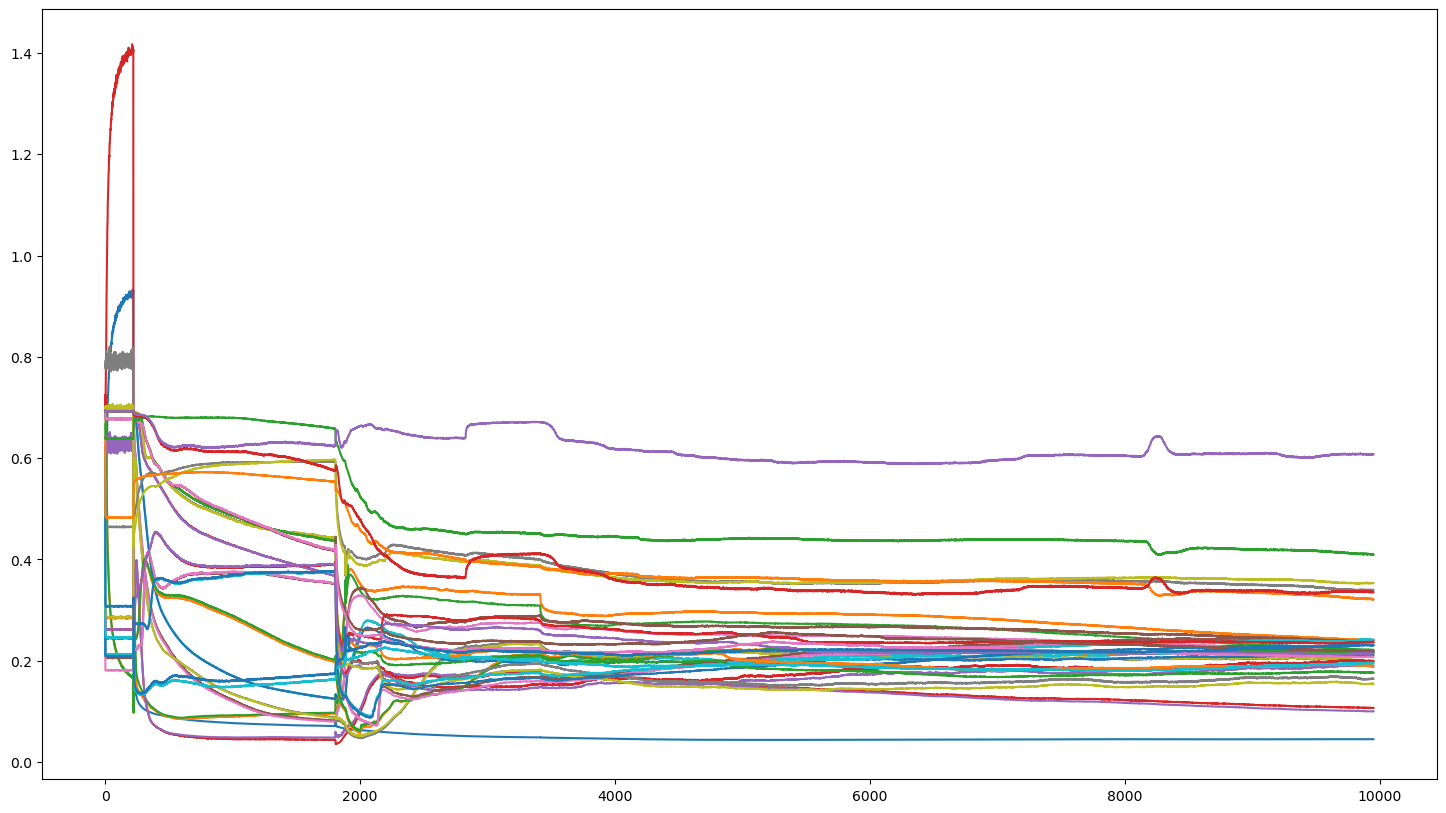

In [58]:
Analytic = Analytic_MNIST_11_19
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
# ax.legend()
plt.show()

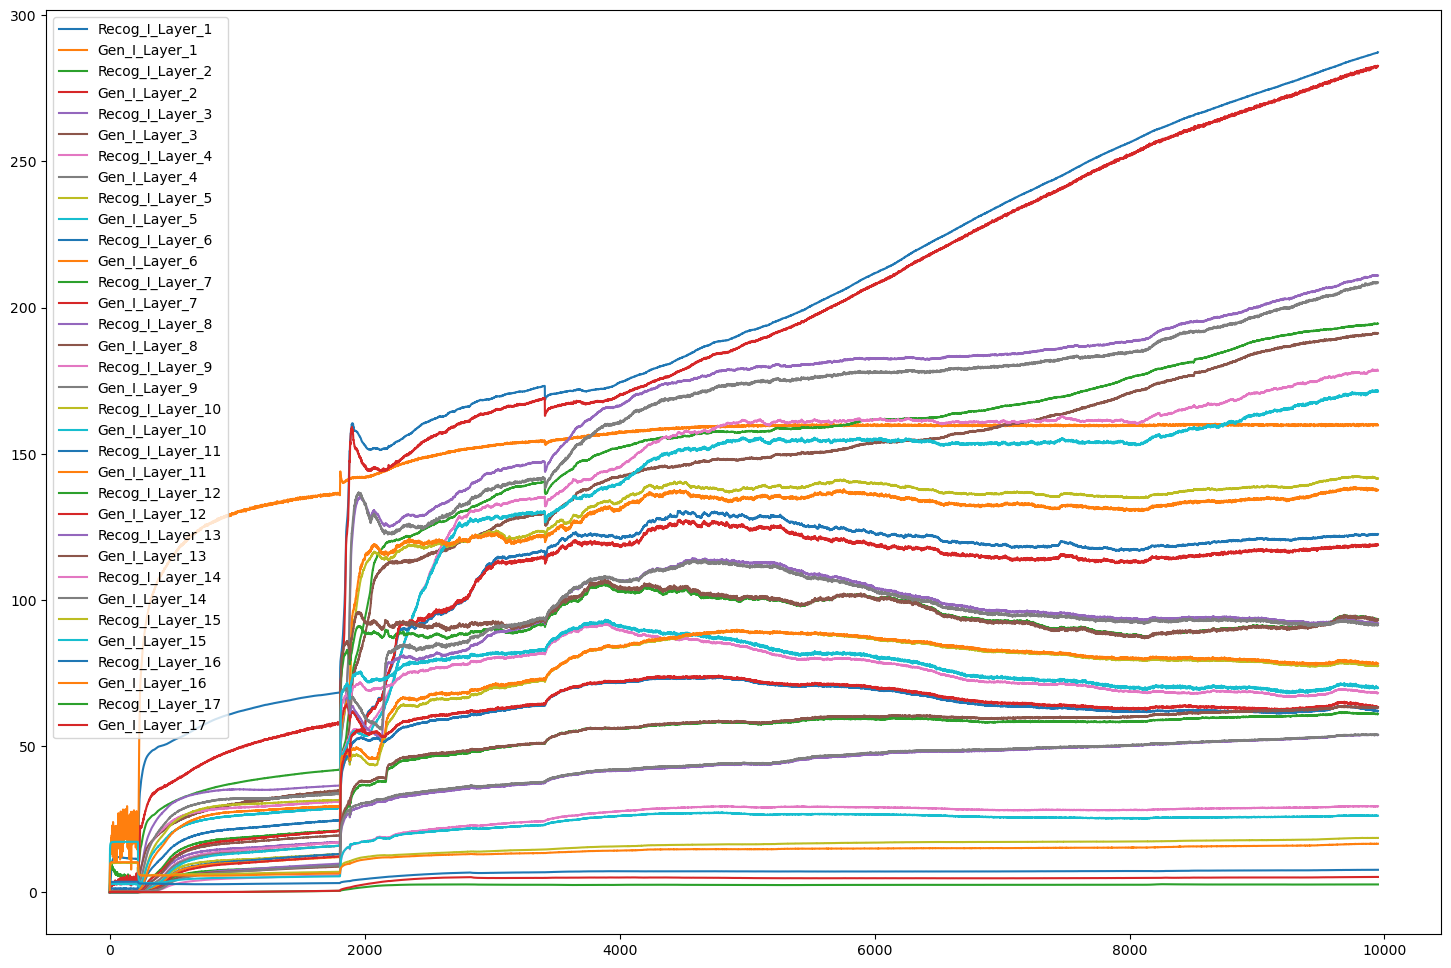

In [59]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_I_Layer_'+str(i)]),label = 'Recog_I_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

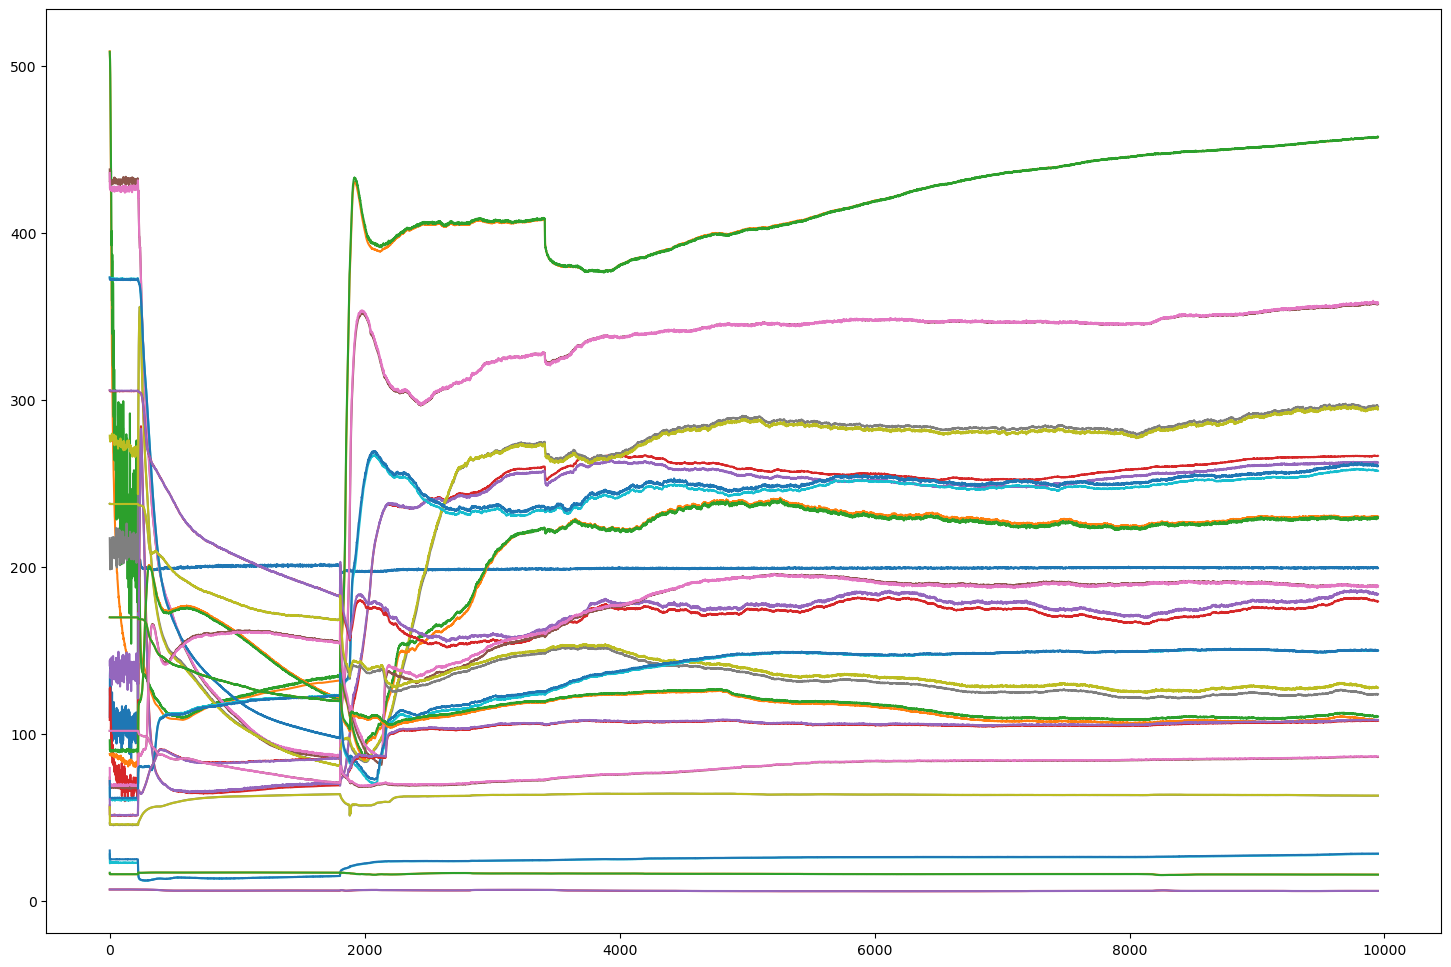

In [155]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(np.array(Analytic['Gen_H_Layer_0']),label = 'Gen_H_Layer_0')
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
# ax.legend()
plt.show()

In [138]:
n_dz[:-1] * np.log(2)

tensor([543.4274, 509.4632, 475.4990, 441.5348, 407.5706, 373.6063, 339.6421,
        305.6779, 271.7137, 237.7495, 203.7853, 169.8211, 135.8568, 101.8926,
         67.9284,  33.9642,  17.3287,   6.9315])

In [60]:
gen_batch_size = 5000
Recog_sample, H_Y_wake, H_YX_wake = wake_sample(Phi,data[:,:5000],dev)
Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)

Layer 0 Data_dist D_KL: 0.4808
Layer 0 Gen_dist D_KL: 0.8083
Layer 1 Recognition Distribution D_KL: 0.3223 H(Y): 457.308 H(Y|X): 168.4719 I_XY: 288.8362
Layer 1 Generative  Distribution D_KL: 0.3222 H(Y): 457.7442 H(Y|X): 176.2729 I_XY: 160.0566
Layer 2 Recognition Distribution D_KL: 0.3653 H(Y): 266.6462 H(Y|X): 71.7528 I_XY: 194.8935
Layer 2 Generative  Distribution D_KL: 0.36 H(Y): 262.5908 H(Y|X): 71.0916 I_XY: 281.4714
Layer 3 Recognition Distribution D_KL: 0.3326 H(Y): 357.1033 H(Y|X): 145.8164 I_XY: 211.2869
Layer 3 Generative  Distribution D_KL: 0.3172 H(Y): 359.3441 H(Y|X): 150.5792 I_XY: 191.4992
Layer 4 Recognition Distribution D_KL: 0.8562 H(Y): 296.4917 H(Y|X): 117.4126 I_XY: 179.0791
Layer 4 Generative  Distribution D_KL: 0.3606 H(Y): 293.7834 H(Y|X): 122.5165 I_XY: 208.7649
Layer 5 Recognition Distribution D_KL: 0.8315 H(Y): 257.5082 H(Y|X): 115.4166 I_XY: 142.0916
Layer 5 Generative  Distribution D_KL: 0.3879 H(Y): 261.7574 H(Y|X): 123.7204 I_XY: 171.2668
Layer 6 Recogn

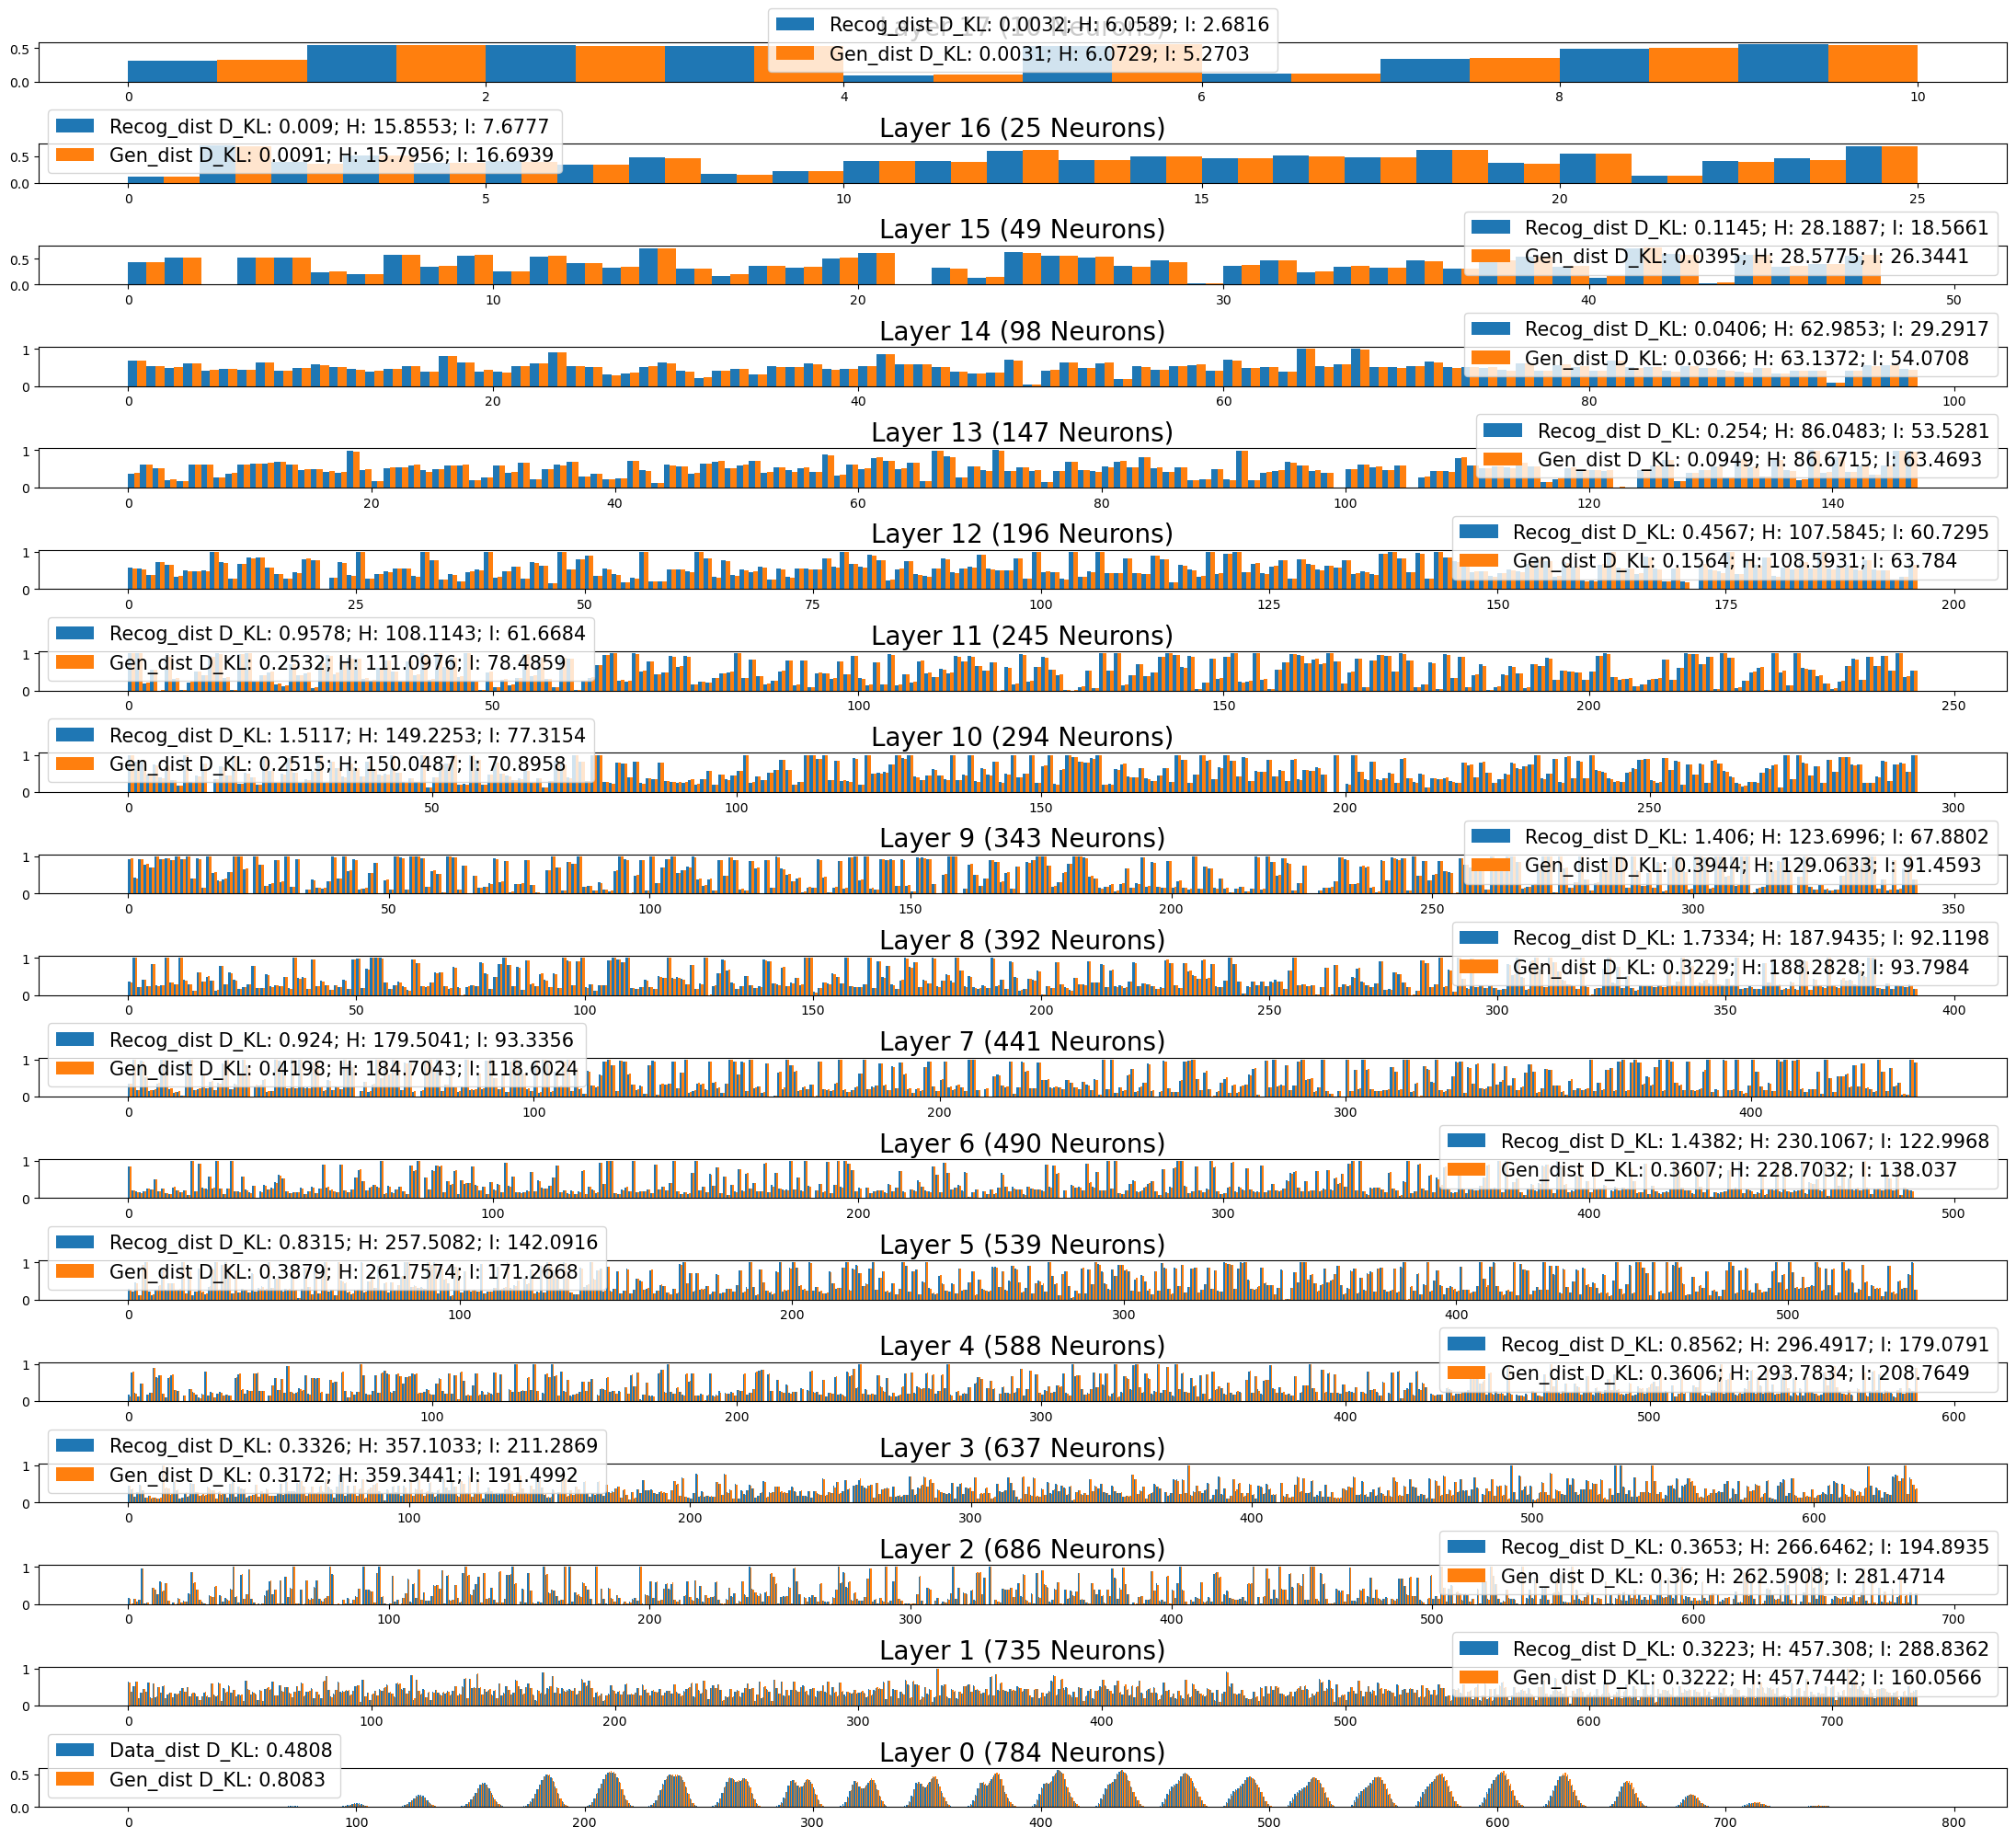

In [61]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 20))
H_Y_wake = H_Y_wake.to('cpu').numpy()
H_YX_wake = H_YX_wake.to('cpu').numpy()
I_wake = H_Y_wake - H_YX_wake
H_Y_sleep = H_Y_sleep.to('cpu').numpy()
H_YX_sleep = H_YX_sleep.to('cpu').numpy()
I_sleep = H_Y_sleep - H_YX_sleep

for i in range(n_layer-1):
    dist_w = Recog_sample['Layer_'+str(i)].float().mean(axis=1)
    dist_s = Gen_sample['Layer_'+str(i)].float().mean(axis=1)
    D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
    D_KL_s = KL_divergence_bernoulli(dist_w,dist_s).item()
    
    if i > 0:
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_wake[i-1],4)), "H(Y|X): "+str(np.around(H_YX_wake[i-1],4)),"I_XY: "+str(np.around(I_wake[i-1],4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_sleep[i],4)), "H(Y|X): "+str(np.around(H_YX_sleep[i],4)),"I_XY: "+str(np.around(I_sleep[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_wake[i-1],4))+ "; I: "+ str(np.around(I_wake[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_sleep[i],4))+ "; I: "+ str(np.around(I_sleep[i-1],4)))
    else:
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4)))
        
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[i].item())+" Neurons)",fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
plt.tight_layout(pad=1)    
plt.show()

In [62]:
gen_batch_size = 10
Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)
gen = Gen_sample["Layer_0"]
gen.shape

torch.Size([784, 10])

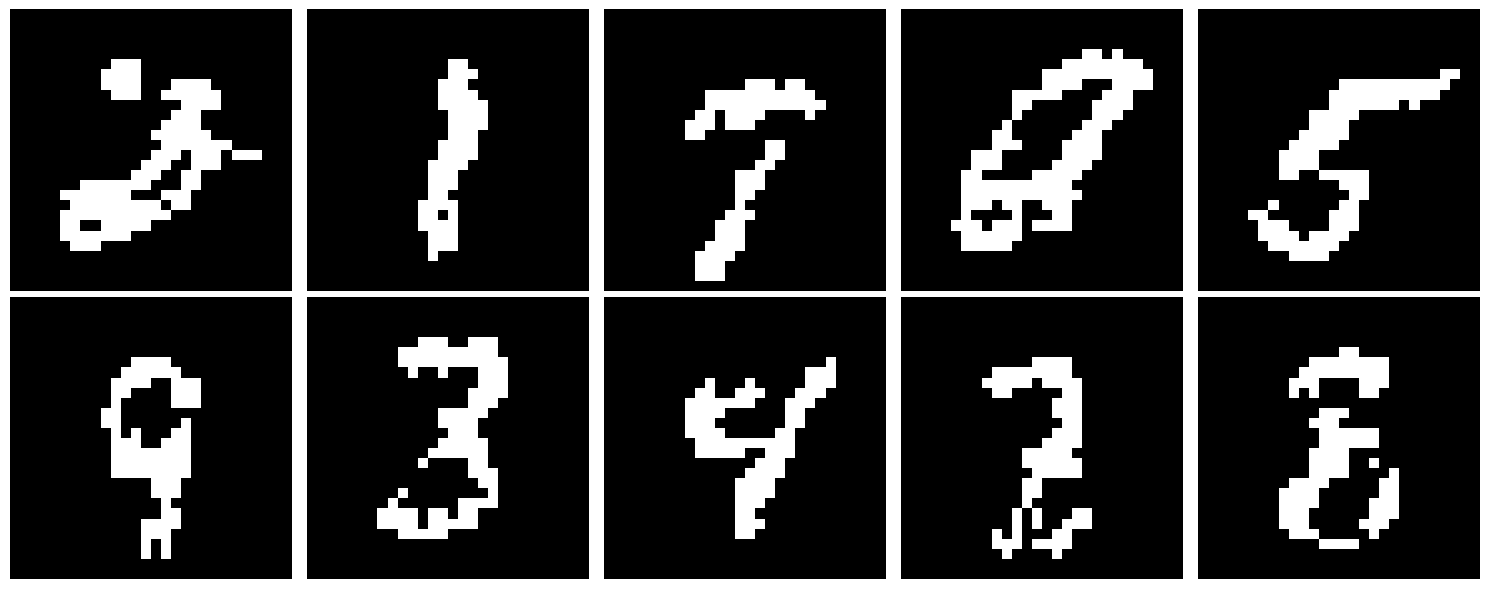

In [63]:
# Create a figure to display the images
fig, axs = plt.subplots(2, 5,figsize=(15, 6))
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(gen[:,i*5+j].reshape(28,28).to('cpu').numpy(), cmap='gray')
        axs[i,j].axis('off')
plt.tight_layout()
plt.show()

In [157]:
Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,30000,dev)

In [165]:
decimalize(Gen_sample['Layer_2'][:40,:],dev).unique().shape

torch.Size([19936])